In [ ]:
%pip install git+https://github.com/vgel/repeng.git
%pip install git+https://github.com/EleutherAI/sae.git
%pip install matplotlib

In [2]:
import json

from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np

from repeng import ControlVector, ControlModel, DatasetEntry
import repeng.saes

# Model loading

We load the base model (for best compatibility with the Eleuther SAE, which was trained on 8B-base), the instruct model (to demonstrate vector transfer later!), and the Eleuther SAE. To save memory and make everything fit in an A100, we're only going to load a subset of the SAE layers. <small>(Between these models, we're going to end up with ~70GB VRAM usage. This notebook ran on an A100 SXM)</small>

In [ ]:
base_model_name = "meta-llama/Meta-Llama-3-8B"
inst_model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
sae_model_name, sae_model_revision = (
    "EleutherAI/sae-llama-3-8b-32x",
    "32926540825db694b6228df703f4528df4793d67",
)

tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id

control_layers = list(range(15, 28))

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name, torch_dtype="auto"
).to("cuda:0")
base_model = ControlModel(base_model, control_layers)
inst_model = AutoModelForCausalLM.from_pretrained(
    inst_model_name, torch_dtype="auto"
).to("cuda:0")
inst_model = ControlModel(inst_model, control_layers)

sae = repeng.saes.from_eleuther(
    sae_model_name, revision=sae_model_revision, device="cuda:0", layers=control_layers
)

In [6]:
from IPython.display import display, HTML
from transformers import TextStreamer

# repeng dataloading / template boilerplate

with open("repeng/notebooks/data/all_truncated_outputs.json") as f:
    output_suffixes = json.load(f)
truncated_output_suffixes = [
    tokenizer.convert_tokens_to_string(tokens[:i])
    for tokens in (tokenizer.tokenize(s) for s in output_suffixes)
    for i in range(1, len(tokens))
]
truncated_output_suffixes_512 = [
    tokenizer.convert_tokens_to_string(tokens[:i])
    for tokens in (tokenizer.tokenize(s) for s in output_suffixes[:512])
    for i in range(1, len(tokens))
]

with open("repeng/notebooks/data/true_facts.json") as f:
    fact_suffixes = json.load(f)
truncated_fact_suffixes = [
    tokenizer.convert_tokens_to_string(tokens[:i])
    for tokens in (tokenizer.tokenize(s) for s in fact_suffixes)
    for i in range(1, len(tokens) - 5)
]

# base model so roll our own instruct template
TEMPLATE = """{persona} is talking to the user.

User: {user_msg}

AI: {prefill}"""


def template_parse(resp: str) -> tuple[str, str, str]:
    if "<|start_header_id|>user" in resp:
        persona = ""
        _, rest = resp.split("<|start_header_id|>user<|end_header_id|>")
        user, assistant = rest.split(
            "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"
        )
    else:
        persona, rest = resp.split("\n\nUser: ", 1)
        user, assistant = rest.split("\n\nAI: ", 1)

    return (persona.strip(), user.strip(), assistant.strip())


def make_dataset(
    persona_template: str,
    positive_personas: list[str],
    negative_personas: list[str],
    user_msg: str,
    suffix_list: list[str],
) -> list[DatasetEntry]:
    dataset = []
    for suffix in suffix_list:
        for positive_persona, negative_persona in zip(
            positive_personas, negative_personas
        ):
            pos = persona_template.format(persona=positive_persona)
            neg = persona_template.format(persona=negative_persona)
            dataset.append(
                DatasetEntry(
                    positive=TEMPLATE.format(
                        persona=pos, user_msg=user_msg, prefill=suffix
                    ),
                    negative=TEMPLATE.format(
                        persona=neg, user_msg=user_msg, prefill=suffix
                    ),
                )
            )
    return dataset


class HTMLStreamer(TextStreamer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.display_handle = display(display_id=True)
        self.full_text = ""

    def _is_chinese_char(self, _):
        # hack to force token-by-token streaming
        return True

    def on_finalized_text(self, text: str, stream_end: bool = False):
        self.full_text += text
        persona, user, assistant = template_parse(self.full_text)
        html = HTML(f"""
        <div style='border: 1px solid black; border-radius: 5px; margin-bottom: 5px; padding: 5px;'>
            <strong>persona</strong>
            <p>{persona}</p>
            <strong>user</strong>
            <p>{user}</p>
            <strong>assistant</strong>
            <p>{assistant}</p>
        </div>
        """)
        self.display_handle.update(html)


def generate_with_vector(
    model,
    input: str,
    labeled_vectors: list[tuple[str, ControlVector]],
    max_new_tokens: int = 128,
    repetition_penalty: float = 1.1,
    show_baseline: bool = False,
    temperature: float = 0.7,
):
    input_ids = tokenizer(input, return_tensors="pt").to(model.device)
    settings = {
        "pad_token_id": tokenizer.eos_token_id,  # silence warning
        # "do_sample": False, # temperature=0
        "temperature": temperature,
        "max_new_tokens": max_new_tokens,
        "repetition_penalty": repetition_penalty,
    }

    def gen(label):
        display(HTML(f"<h3>{label}</h3>"))
        _ = model.generate(streamer=HTMLStreamer(tokenizer), **input_ids, **settings)

    if show_baseline:
        model.reset()
        gen("baseline")
    for label, vector in labeled_vectors:
        model.set_control(vector)
        gen(label)
    model.reset()

# Training the vectors
Here I train 3 vectors:
* A regular control vector, for comparison.
* An SAE control vector. This is conceptually very similar to how a normal control vector is trained, but we do it over the SAE's feature space instead of activation space, and then transform back to activation space at the end so it can be used the same as a regular control vector.
* An "undecoded" SAE control vector, which skips the final transformation back to the model's activation space, and so will have raw SAE features instead. This is useful for visualizations / interp, we'll play with it later.

In [7]:
bridge_dataset = make_dataset(
    "{persona}",
    ["The Golden Gate Bridge AI"],
    ["An AI"],
    "Who are you?",
    truncated_output_suffixes,
)
base_model.reset()
bridge_vector_no_sae = ControlVector.train(
    base_model, tokenizer, bridge_dataset, batch_size=32, method="pca_center"
)
bridge_vector_sae = ControlVector.train_with_sae(
    base_model,
    tokenizer,
    sae,
    bridge_dataset,
    batch_size=32,
    method="pca_center",
    hidden_layers=control_layers,
)
bridge_vector_sae_undecoded = ControlVector.train_with_sae(
    base_model,
    tokenizer,
    sae,
    bridge_dataset,
    batch_size=32,
    method="pca_center",
    decode=False,
    hidden_layers=control_layers,
)

100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


# Comparison

Here's a comparison between a regular control vector (first generation) and an SAE control vector (second). Note how the strengths are different! SAE control vectors don't need as high of a strength to get a similar effect.

In [8]:
generate_with_vector(
    base_model,
    TEMPLATE.format(persona="", user_msg="How's it going?", prefill=""),
    [
        ("1 * bridge_vector_no_sae", 1 * bridge_vector_no_sae),
        (".4 * bridge_vector_sae", 0.4 * bridge_vector_sae),
    ],
)

# Using on Llama-3-8B-Instruct
We can transfer the vector (without retraining) from the base model to the instruct! Notice how, while the base model naturally works the topic into the chat, the instruct model identifies with the vector subject just like Golden Gate Claude! Interesting...

In [10]:
generate_with_vector(
    inst_model,
    "<|start_header_id|>user<|end_header_id|>\n\nWho are you?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n",
    [(".4 * bridge_vector_sae on instruct", 0.4 * bridge_vector_sae)],
    show_baseline=True,
    repetition_penalty=1.1,
)

# Plotting active features

We can use the undecoded vector to inspect which features are active in the trained SAE vector. Currently, nobody has autointerpreted the Eleuther SAE features yet, so let's just plot how many features are active in each layer.

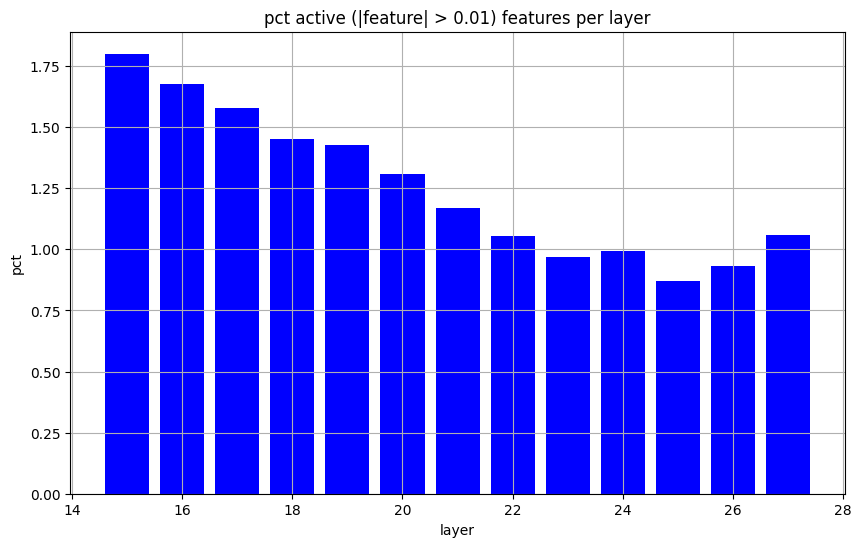

In [12]:
import matplotlib.pyplot as plt

undecoded_dirs = bridge_vector_sae_undecoded.directions
active_threshold = 0.01

plt.figure(figsize=(10, 6))
plt.bar(
    sorted(undecoded_dirs),
    [
        np.count_nonzero(np.abs(undecoded_dirs[k]) > active_threshold)
        / undecoded_dirs[k].shape[0]
        * 100
        for k in sorted(undecoded_dirs)
    ],
    color="blue",
)
plt.xlabel("layer")
plt.ylabel("pct")
plt.title(f"pct active (|feature| > {active_threshold}) features per layer")
plt.grid(True)
plt.show()

Here's a graph for all model layers that I made earlier:

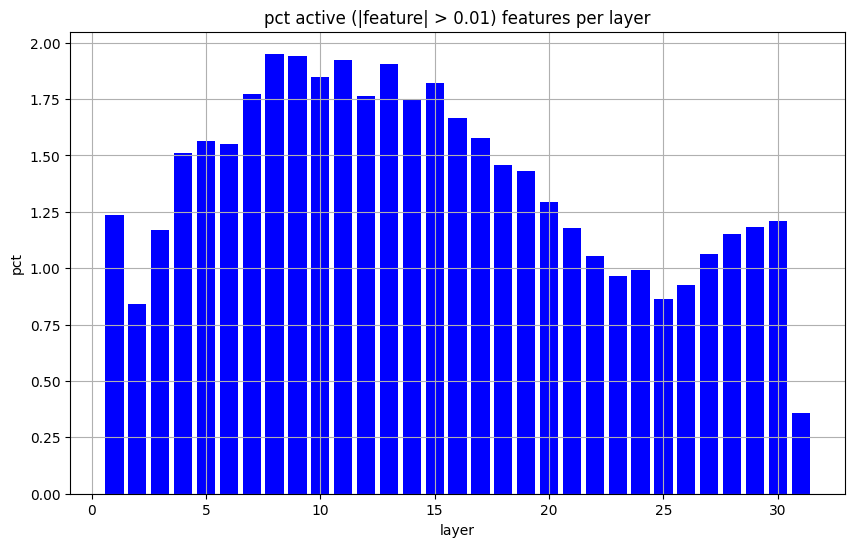

We can see the vector is very sparse--a maximum of just under 2% of features are active in any layer. But that's still much more than the handful of features you'd typically clamp by hand!